# 0. Setup

In [1]:
! rm -rf /content/sample_data
! mkdir saved_models

## Imports

In [2]:
import os
import time
import random
import gc
import multiprocessing
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from google.colab import drive
from shutil import copyfile

import pandas as pd
from pandas import DataFrame
import seaborn as sns

## Setup GPU

In [3]:
use_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
if device.type == 'cuda':
  print('CUDA is available. Training on GPU')
else:
  print('CUDA is not available. Training on CPU')

CUDA is available. Training on GPU


# 1. Download Data

## Download Data


### Upload Data manually (DEPRECATED)

.    
└── 📁 aps360_project_db.zip     
    └── 📁 aps360_project_db   
     └── 📁 DATASET   
        ├── 📁 TEST  
            ├── 📁 O  
            └── 📁 R   
        └── 📁 TRAIN    
            ├── 📁 O  
            └── 📁 R   

In [ ]:
%%capture
%%bash
unzip /content/aps360_project_db
rm -f /content/aps360_project_db.zip

In [ ]:
train_data_dir = "/content/aps360_project_db/DATASET/TRAIN"
test_data_dir = "/content/aps360_project_db/DATASET/TEST"

### Download Data from Google Drive

In [4]:
def download_data(train=True):
    """ Function to download data from google drive
        Args:
            train: specifies whether to download train or test data
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'My Drive'

    if train:
        file_name = 'aps360_project_db_train.zip'
    else:
        file_name = 'aps360_project_db_test.zip'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # copy dependencies from gdrive into colab 
    os.makedirs('./rawdata', exist_ok=True)
    copyfile(data_path, "./rawdata/" + file_name)

    # unmount gdrive
    drive.flush_and_unmount()

def unzip_data(train=True):
    """ Function to unzip dataset
        Args:
            train: specifies whether to download train or test data
    """
    if train:
        ! unzip /content/rawdata/aps360_project_db_train.zip
        ! rm -rf /content/rawdata/
    else:
        ! unzip /content/rawdata/aps360_project_db_test.zip
        ! rm -rf /content/rawdata/

def delete_data(train=True):
    """ Function to delete dataset
        Args:
            train: specifies whether to download train or test data
    """
    if train:
        ! rm -rf /content/TRAIN
    else:
        ! rm -rf /content/TEST

### Download training data  

.    
└── 📁 TRAIN    
  ├── 📁 O  
  └── 📁 R   

In [5]:
train_data_dir = "/content/TRAIN"

In [6]:
%%capture
download_data(train=True)
unzip_data(train=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7REfqGshwmuM855xaPxUU6DcXfAZpnmj4sJoa3vSc4Plw12EdpwuQ


In [ ]:
# delete_data(train=True)

### Download test data  

.    
└── 📁 TEST    
  ├── 📁 O  
  └── 📁 R   

In [7]:
test_data_dir = "/content/TEST"

In [8]:
%%capture
download_data(train=False)
unzip_data(train=False)

In [ ]:
# delete_data(train=False)

# 2. Split Data

In [9]:
# Source: https://github.com/ufoym/imbalanced-dataset-sampler
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [10]:
def create_dataset(train=True):
    """ Load data from file system and create a dataset
    Args:
        train: choose between training set and test set
    Returns:
        dataset 
    """
    # convert images to (224 x 224)
    data_transform = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ColorJitter(brightness=0.1, hue=0.05, saturation=0.01),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(35),
                                        transforms.ToTensor()])

    # load dataset
    if train:
        return datasets.ImageFolder(train_data_dir, transform=data_transform)  
    else:
        return datasets.ImageFolder(test_data_dir, transform=data_transform)
  
def split_data(dataset, train=True, train_ratio=0.7, batch_size=25, 
                                                    seed=1000, shuffle=True):
    """ Load data from dataset and split it into train/valid/test sets
    Args:
        dataset: dataset containing all data
        train: determines if dataset is for the train or the test set. 
                If it's the test set, don't split
        train_ratio: percentage of data to go into training set
        batch_size: batch size for dataloader
        seed: random seed
        shuffle: flag on whether the shuffle original dataset or not
    Returns:
        train_loader: training dataloader
        valid_loader: validation dataloader
        test_loader: test dataloader    
    """
    # number of examples in dataset
    num_data = len(dataset)

    # shuffle data
    if shuffle:
        torch.manual_seed(seed)
        indices = torch.randperm(num_data)
    else:
        indices = torch.arange(num_data)

    # dataloader parameters
    num_workers = multiprocessing.cpu_count()
    prefetch_factor = 8
    pin_mem = False
    if torch.cuda.is_available():
        pin_mem = True

    if train:
        # calculate indices to split data at
        split = int(np.floor(train_ratio * num_data))

        # train/valid split
        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = torch.utils.data.Subset(dataset, train_idx)
        valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

        # create Data loaders
        train_loader = DataLoader(dataset, 
                                  batch_size=batch_size, 
                                  sampler=ImbalancedDatasetSampler(train_sampler), 
                                  num_workers=num_workers, 
                                  pin_memory=pin_mem,
                                  prefetch_factor=prefetch_factor)
        
        valid_loader = DataLoader(dataset, 
                                  batch_size=batch_size, 
                                  sampler=valid_sampler, 
                                  num_workers=num_workers, 
                                  pin_memory=pin_mem,
                                  prefetch_factor=prefetch_factor)
        
        return train_loader, valid_loader

    else:
        # all data placed in test set
        test_idx = indices
        test_sampler = SubsetRandomSampler(test_idx)

        test_loader = DataLoader(dataset, 
                                 batch_size=batch_size, 
                                 sampler=test_sampler, 
                                 num_workers=num_workers, 
                                 pin_memory=pin_mem,
                                 prefetch_factor=prefetch_factor)
        
        return test_loader

def split_classes(dataloader, seed=1000, batch_size=25):
    """ Splits data between 2 classes (organic and recyclable)
    Args:
        dataloader: dataloader of data to split
        seed: random seed. Use same seed as when you split data (preferably)
    Returns:
        organic_dataset: organic data dataset
        recycle_dataset: recyclable data dataset
        organic_dataloader: organic data dataloader
        recycle_dataloader: recyclable data dataloader
    """
    # set seed
    torch.manual_seed(seed)
    
    # dataloader parameters
    num_workers = 0
    pin_mem = False
    if torch.cuda.is_available():
        pin_mem = True

    organic_imgs = []
    organic_labels = []
    recyclable_imgs = []
    recyclable_labels = []

    # loop through data in dataloader and split into 2 classes
    # organic == 0, recyclable == 1
    for img_batch, label_batch in dataloader:
        for j in range(len(label_batch)):
            if label_batch[j] == 0:
                organic_imgs.append(img_batch[j])
                organic_labels.append(label_batch[j])
            else:
                recyclable_imgs.append(img_batch[j])
                recyclable_labels.append(label_batch[j])

    # convert to tensors
    t_organic_imgs = torch.stack(organic_imgs)
    t_organic_labels = torch.stack(organic_labels)
    t_recyclable_imgs = torch.stack(recyclable_imgs)
    t_recyclable_labels = torch.stack(recyclable_labels)

    # free memory
    organic_imgs = None
    del organic_imgs
    organic_labels = None
    del organic_labels
    recyclable_imgs = None
    del recyclable_imgs
    recyclable_labels = None
    del recyclable_labels

    # convert to Dataset objects
    organic_dataset = TensorDataset(t_organic_imgs, t_organic_labels)
    recycle_dataset = TensorDataset(t_recyclable_imgs, t_recyclable_labels)

    # free memory
    t_organic_imgs = None
    del t_organic_imgs
    t_organic_labels = None
    del t_organic_labels
    t_recyclable_imgs = None
    del t_recyclable_imgs
    t_recyclable_labels = None
    del t_recyclable_labels

    gc.collect()

    # construct DataLoaders
    organic_dataloader = DataLoader(organic_dataset, 
                                    batch_size=batch_size,
                                    num_workers=num_workers, 
                                    pin_memory=pin_mem)
    
    recycle_dataloader = DataLoader(recycle_dataset,
                                    batch_size=batch_size,
                                    num_workers=num_workers, 
                                    pin_memory=pin_mem)
    
    return organic_dataset, recycle_dataset, organic_dataloader, recycle_dataloader

In [11]:
# create train dataset
train_dataset = create_dataset(train=True)

In [12]:
train_loader, valid_loader = split_data(train_dataset,
                                        train=True,
                                        train_ratio=0.7, 
                                        batch_size=1,             
                                        seed=10, 
                                        shuffle=False)

In [13]:
print(f"Number of examples in dataset: {len(train_dataset)}")
print(f"Number of training examples: {len(train_loader)}")
print(f"Number of validation examples: {len(valid_loader)}")

Number of examples in dataset: 22564
Number of training examples: 15794
Number of validation examples: 6770


In [14]:
# uncomment to create positive and negative datasets from validation dataloader
# neg_ds, pos_ds, neg_dl, pos_dl = split_classes(valid_loader, 1, 20)

# [warning] duplicating data may cause RAM to crash make sure to free data by
# doing the following
# neg_ds = None
# del neg_ds
# ...
# gc.collect()

# 3. Visualize Data

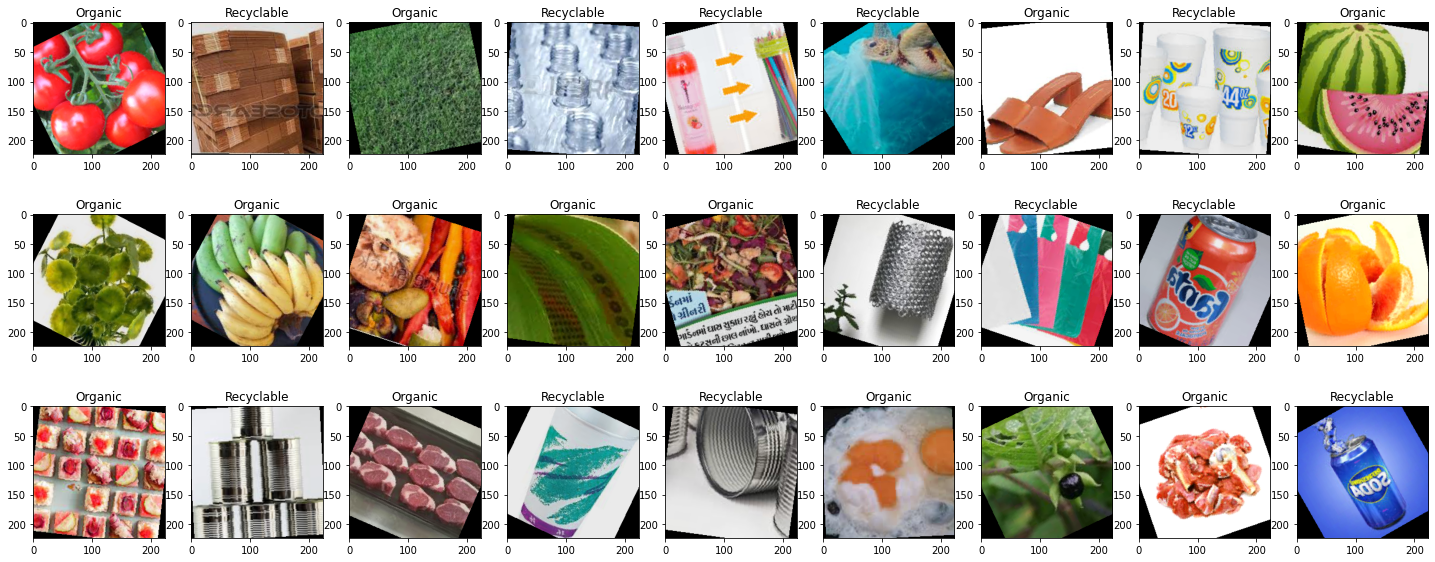

In [15]:
test_dataset = create_dataset(train=False)

classes = ['Organic', 'Recyclable']
batch_size = 1
num_sample_batches = 27
num_cols = 9
num_rows = num_sample_batches / num_cols

train_iter = iter(train_loader)
fig = plt.figure(figsize=(25, 10))

for i in range(num_sample_batches):
    for j in range(batch_size):
      imgs, labels = train_iter.next()
      ax = fig.add_subplot(num_rows, num_cols, i + 1)
      plt.imshow(np.transpose(imgs[j], (1, 2, 0)))
      ax.set_title(classes[labels[j]])

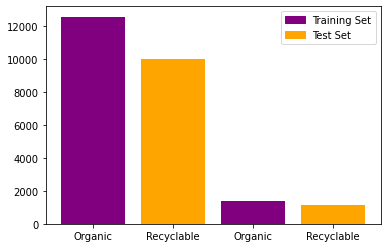

In [16]:
# Bar graph of number organic and recyclable examples
train_classes_dict = dict(Counter(train_dataset.targets))
test_classes_dict = dict(Counter(test_dataset.targets))
height = [train_classes_dict.get(0), train_classes_dict.get(1), test_classes_dict.get(0), test_classes_dict.get(1)]
bars = ('Organic', 'Recyclable', 'Organic', 'Recyclable')
x_pos = np.arange(len(bars))

plt.bar(x_pos, height, color=['purple', 'orange'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Add a legend
colors = {'Training Set':'purple', 'Test Set':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

# 4. Define Model

In [17]:
def get_num_params(net):
    """determine the size of the model
    Args:
        net: machine learning model
    Returns:
        size of model
    """
    return sum(p.numel() for p in net.parameters())

In [18]:
# Base CNN model
class CNN(nn.Module):
    def __init__(self, nin: int, nout: int, k=5, s=1):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(nin, nout, kernel_size=k, stride=s)

    def forward(self, x):
        x = F.relu(self.conv(x))
        return x 

class WasteClassifier(nn.Module):
    def __init__(self, get_size=False):
        super(WasteClassifier, self).__init__()
        self.get_size = get_size
        self.resnet_feature_extractor = models.resnet18(pretrained=True)
        self.resnet_feature_extractor = nn.Sequential(*list(self.resnet_feature_extractor.children())[:-3])
        for param in self.resnet_feature_extractor.parameters():
            param.requires_grad = False

        self.conv = nn.Sequential(
            CNN(nin=256, nout=512),
            nn.MaxPool2d(2, 2),
            CNN(nin=512, nout=512),
            nn.Dropout()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        x = self.resnet_feature_extractor(x)
        if self.get_size:
            print("resnet feature layer size: ", x.size())
        x = self.conv(x)
        x = self.flatten(x)
        if self.get_size:
            print("flattened layer size: ", x.size())
        x = self.fc(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x

In [20]:
print(f"Number of parameters in model: {get_num_params(WasteClassifier())}")

Number of parameters in model: 12647105


# 5. Training Code

In [21]:
def save_model(model, filename=""):
    """ Save a model for inference for later use
    Args:
        model: trained machine learning model to be saved
        filename: name of file
    """
    PATH = ""
    if filename == "":
        PATH = "/content/saved_models/" + str(random.randint(1,100000))
    else:
        PATH = "/content/saved_models/" + filename
    torch.save(model.state_dict(), PATH)

def load_model(model, PATH, device):
    """ Load a previously saved model
    Args:
        model: model with same architecture as the one you're trying to load
        PATH: file path to load from
        device: device (cpu or gpu) to load the model into
    """
    model.load_state_dict(torch.load(PATH, map_location=device))

def upload_model_to_drive(PATH, file_name=""):
    """ Upload a saved model to google drive
    Args:
        model: saved machine learning model
        PATH: path to model in current session
        file_name: file name to be saved in google drive
    """
    if file_name == "":
        file_name = os.path.basename(PATH)

    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'My Drive'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # copy to drive
    copyfile(PATH, data_path)

    # unmount gdrive
    drive.flush_and_unmount()

def download_model_from_drive(file_name):
    """ Download a model from google drive to current session
    Args:
        file_name: name of file
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'MyDrive'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # copy from drive
    PATH = "/content/saved_models/" + file_name
    copyfile(data_path, PATH)

    # unmount gdrive
    drive.flush_and_unmount()

def load_model_from_drive(model, device, file_name):
    """ Directly load a pytorch model saved in google drive
    Args:
        model: empty pytorch model with same architecure as the one being loaded
        device: location to load model (cpu or gpu)
        file_name: name of file where model is saved to
    """
    gdrive_path = Path('./drive')
    gdrive_dir = 'aps360'

    # mount your google drive to colab 
    drive.mount(gdrive_path.as_posix())
    gdrive_path  /= 'MyDrive'

    # get file path
    data_path = gdrive_path / gdrive_dir / file_name

    # load model from drive
    model.load_state_dict(torch.load(data_path, map_location=device))

    # unmount gdrive
    drive.flush_and_unmount()

In [23]:
def get_optimizer(model, params):
    """ Get an optimizer for your model
    Args:
        model: machine learning model
        params: dictionary of hyperparameters for model
    Returns:
        optimizer for model based on params
    """
    
    if params.get('optim') == 'RMS':
        return optim.RMSprop(model.parameters(),
                            lr=params.get('lr', 0.01), 
                            momentum=params.get('mm', 0.0),
                            weight_decay=params.get('wd', 0.0))
    elif params.get('optim') == 'ADAM':
        return optim.Adam(model.parameters(), 
                            lr=params.get('lr', 0.001),
                            weight_decay=params.get('wd', 0.0))
    else:
        return optim.SGD(model.parameters(), 
                            lr=params.get('lr', 0.01), 
                            momentum=params.get('mm', 0.0),
                            weight_decay=params.get('wd', 0.0))
        
@torch.no_grad()
def evaluate(model, val_loader, criterion):
    """ Compute accuracy and loss of the model on the validation set
     Args:
        model: machine learning model
        val_loader: dataloader for the validation set
        criterion: loss function
     Returns:
         acc: the accuracy of the model
         loss: the loss of the model
     """
    total_loss = 0.0
    total_acc = 0.0
    total_examples = 0
    for i, (imgs, labels) in enumerate(val_loader, 0):
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)
        loss = criterion(out, labels.float())

        # converts to 0 (organic) or 1 (recyclable) and compares with label
        pred = (out >= 0.0).squeeze().long() == labels 

        # calculate accuracy and loss
        total_acc += sum(pred).item()
        total_loss += loss.item()
        total_examples += len(labels)    

    acc = float(total_acc) / total_examples   
    loss = float(total_loss) / (i+1)   
    return acc, loss

@torch.no_grad()
def test_accuracy(model, test_loader):
    """ Compute accuracy of the model on the test set
     Args:
        model: machine learning model
        test_loader: dataloader for the test set
     Returns:
         acc: the accuracy of the model
     """
    total_acc = 0.0
    total_examples = 0
    for imgs, labels in test_loader:
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)

        # converts to 0 (organic) or 1 (recyclable) and compares with label
        pred = (out >= 0.0).squeeze().long() == labels 

        # calculate accuracy
        total_acc += sum(pred).item()
        total_examples += len(labels)

    acc = float(total_acc) / total_examples   
    return acc

@torch.no_grad()
def plot_confusion_matrix(model, dataloader):
    confusion_matrix = np.zeros((2, 2))
    
    for (imgs, labels) in dataloader:
        # use GPU if available
        imgs = imgs.to(device)
        labels = labels.to(device)

        # get predictions
        out = model(imgs)
        pred = (out >= 0.0).squeeze().long()
        for p, l in zip(pred, labels):
            confusion_matrix[p.long(), l.long()] += 1

    # plot heatmap
    plt.figure(figsize=(9,6))
    classes = ['organic', 'recyclable']
    df = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df, annot=True, fmt="d")

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    plt.xlabel('Real label')
    plt.ylabel('Predicted label')

    # calculate accuracy
    TP = confusion_matrix[0][0]
    TN = confusion_matrix[1][1]
    acc = (TP + TN) / confusion_matrix.sum()
    print(f"Accuracy: {acc:.8f}")

def plot_loss_acc(num_epochs, train_loss, train_acc, val_loss, val_acc):
    """ Plot training curves
    Args:
        num_epochs: number of epochs to plot
        train_loss: list of training losses
        train_acc: list of training accuracies
        val_loss: list of validation losses
        val_acc: list of validation accuracies
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))  
    fig.subplots_adjust(wspace=0.4)

    axes[0].set_title("Training & Validation Loss")
    axes[0].plot(range(1,num_epochs+1), train_loss, label="Training")
    axes[0].plot(range(1,num_epochs+1), val_loss, label="Validation")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend(loc='best')

    axes[1].set_title("Training & Validation Accuracy")
    axes[1].plot(range(1,num_epochs+1), train_acc, label="Training")
    axes[1].plot(range(1,num_epochs+1), val_acc, label="Validation")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend(loc='best')

    plt.show()

def train(model, train_loader, val_loader, params, plot=False, show_updates=False):
    """ Train the model and plot the learning curves
     Args:
        model: machine learning model
        train_loader: dataloader for the training set
        val_loader: dataloader for the validation set
        device: torch.device object. Either 'cpu' or 'cuda'
        params: dictionary of hyperparameters for model
        plot: flag to display training curves
        show_updates: flag to display training updates each epoch
     """

    num_epochs = params.get('epoch', 10)
    criterion = nn.BCEWithLogitsLoss()   # expects targets to be of type torch.long
    optimizer = get_optimizer(model, params)
   
    train_acc, train_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    val_acc, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)

    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_examples = 0

        for i, (imgs, labels) in enumerate(train_loader):
            # use GPU if available
            imgs = imgs.to(device)
            labels = labels.to(device)

            # training
            out = model(imgs)
            loss = criterion(out, labels.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # converts to 0 (organic) or 1 (recyclable) and compares with label
            pred = (out >= 0.0).squeeze().long() == labels 

            # calculate accuracy and loss
            total_train_acc += sum(pred).item()
            total_train_loss += loss.item()
            total_examples += len(labels)

        train_acc[epoch] = float(total_train_acc) / total_examples   
        train_loss[epoch] = float(total_train_loss) / (i+1)   
        val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
        
        # print updates each epoch
        if show_updates:
            print(f"Epoch {epoch + 1: <2} | "
                    f"Train acc: {train_acc[epoch]:<12.8f} | "
                    f"Train loss: {train_loss[epoch]:<12.8f} | "
                    f"Val acc: {val_acc[epoch]:<12.8f} | "
                    f"Val loss: {val_loss[epoch]:<12.8f}")
            
    # print final updates
    if not show_updates:
        print(f"Epoch {epoch + 1: <2} | "
                f"Train acc: {train_acc[epoch]:<12.8f} | "
                f"Train loss: {train_loss[epoch]:<12.8f} | "
                f"Val acc: {val_acc[epoch]:<12.8f} | "
                f"Val loss: {val_loss[epoch]:<12.8f}")

    # time taken 
    end_time = time.time()
    print (f"Total time: {end_time-start_time: .2f}s")

    if plot:
        plot_loss_acc(num_epochs, train_loss, train_acc, val_loss, val_acc)

    return

# 6. Experimentation

Epoch 1  | Train acc: 0.74085096   | Train loss: 0.59897935   | Val acc: 0.76543575   | Val loss: 0.50373606  
Epoch 2  | Train acc: 0.78485501   | Train loss: 0.46528170   | Val acc: 0.80487445   | Val loss: 0.44042323  
Epoch 3  | Train acc: 0.78485501   | Train loss: 0.45977710   | Val acc: 0.81166913   | Val loss: 0.45446315  
Epoch 4  | Train acc: 0.79276941   | Train loss: 0.44529789   | Val acc: 0.75849335   | Val loss: 0.50947219  
Epoch 5  | Train acc: 0.79903761   | Train loss: 0.44371806   | Val acc: 0.77075332   | Val loss: 0.49423013  
Epoch 6  | Train acc: 0.80606559   | Train loss: 0.43007364   | Val acc: 0.76794682   | Val loss: 0.54195439  
Epoch 7  | Train acc: 0.80087375   | Train loss: 0.43974494   | Val acc: 0.79926145   | Val loss: 0.47208429  
Epoch 8  | Train acc: 0.80505255   | Train loss: 0.43384423   | Val acc: 0.78966027   | Val loss: 0.46339319  
Epoch 9  | Train acc: 0.80986451   | Train loss: 0.41409821   | Val acc: 0.80059084   | Val loss: 0.45910121  
E

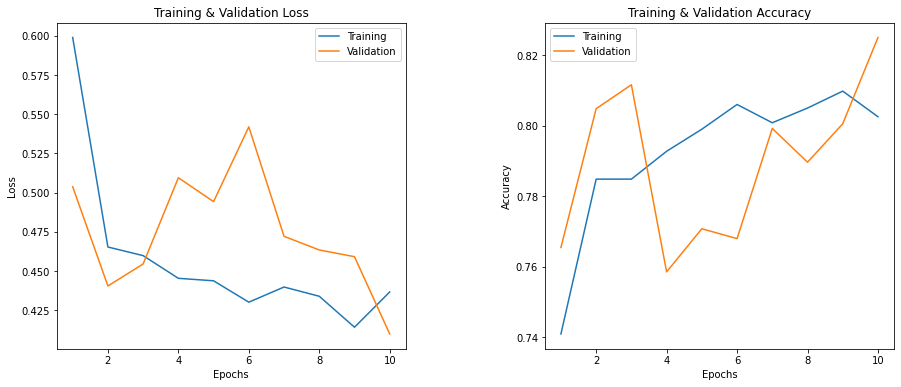

In [ ]:
params = {'batch':108, 'epoch':10, 'optim':'ADAM', 'lr':0.002, 'mm':0.0, 'wd':5e-3, 'seed':10}

train_loader, valid_loader = split_data(train_dataset, 
                                        train=True, 
                                        train_ratio=0.7, 
                                        batch_size=params.get('batch'), 
                                        seed=params.get('seed'),
                                        shuffle=True)

model = WasteClassifier()
model.to(device)
# performance improvements when model inputs don't change
torch.backends.cudnn.benchmark = True

train(model, train_loader, valid_loader, params, plot=True, show_updates=True)

Epoch 1  | Train acc: 0.75009497   | Train loss: 0.54307439   | Val acc: 0.80073855   | Val loss: 0.45205698  
Epoch 2  | Train acc: 0.79011017   | Train loss: 0.45619730   | Val acc: 0.80841950   | Val loss: 0.44379168  
Epoch 3  | Train acc: 0.79061669   | Train loss: 0.45617682   | Val acc: 0.80236337   | Val loss: 0.46088557  
Epoch 4  | Train acc: 0.79777131   | Train loss: 0.43614978   | Val acc: 0.79246677   | Val loss: 0.46313888  
Epoch 5  | Train acc: 0.80505255   | Train loss: 0.43523707   | Val acc: 0.80635155   | Val loss: 0.44818334  
Epoch 6  | Train acc: 0.80980119   | Train loss: 0.42514695   | Val acc: 0.79364845   | Val loss: 0.45984445  
Epoch 7  | Train acc: 0.80954793   | Train loss: 0.42693824   | Val acc: 0.81137371   | Val loss: 0.43537999  
Epoch 8  | Train acc: 0.80638217   | Train loss: 0.43122712   | Val acc: 0.81344165   | Val loss: 0.43188015  
Epoch 9  | Train acc: 0.81372673   | Train loss: 0.41442861   | Val acc: 0.81240768   | Val loss: 0.43195671  
E

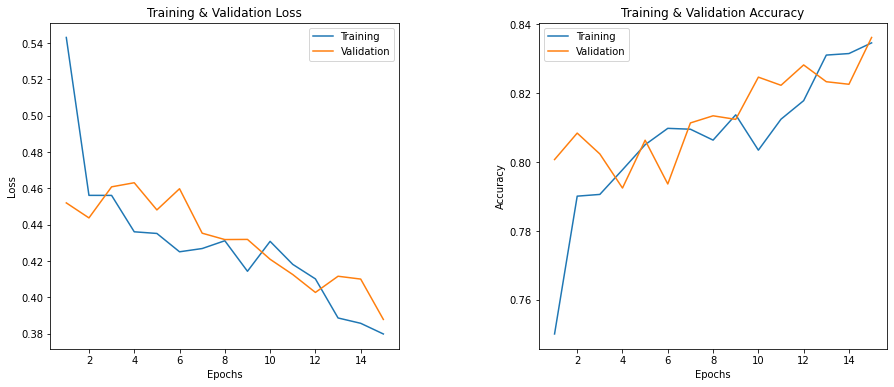

In [ ]:
params = {'batch':128, 'epoch':15, 'optim':'ADAM', 'lr':0.001, 'mm':0.0, 'wd':5e-3, 'seed':10}

train_loader, valid_loader = split_data(train_dataset, 
                                        train=True, 
                                        train_ratio=0.7, 
                                        batch_size=params.get('batch'), 
                                        seed=params.get('seed'),
                                        shuffle=True)

model = WasteClassifier()
model.to(device)
# performance improvements when model inputs don't change
torch.backends.cudnn.benchmark = True

train(model, train_loader, valid_loader, params, plot=True, show_updates=True)

In [ ]:
params = {'batch':62, 'seed':10}

test_dataset = create_dataset(train=False)
test_loader = split_data(test_dataset,
                        train=False,
                        batch_size=params.get('batch'), 
                        seed=params.get('seed'),
                        shuffle=True)

Test Accuracy: 0.55750099


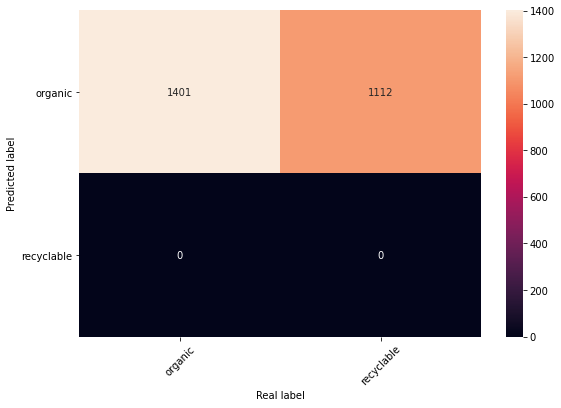

In [ ]:
plot_confusion_matrix(model, test_loader)
print(f"Test Accuracy: {test_accuracy(model, test_loader):.8f}")

In [ ]:
"""
Save a model to local file system
"""
save_model(model)

In [ ]:
"""
Load a saved model from local file system
"""
new_model = WasteClassifier()
load_model(new_model, "/content/saved_models/58870", device)
new_model.to(device)

In [ ]:
"""
Upload a saved model from local file system to Google Drive 
"""
PATH = "/content/saved_models/58870"
upload_model_to_drive(PATH, file_name="58870")

In [ ]:
"""
Download a saved model from Google Drive to local file system
"""
download_model_from_drive("58870")

In [ ]:
"""
Load a saved model from Google Drive
"""
new_model = WasteClassifier()
load_model_from_drive(new_model, device, "58870")
new_model.to(device)

In [ ]:
# Test accuracy for false positives and negatives
neg_ds, pos_ds, neg_dl, pos_dl = split_classes(test_loader, 10, 62)
print(f"Accuracy on Organic set: {test_accuracy(model, neg_dl)},\
     Accuracy on Recyclable set: {test_accuracy(model, pos_dl)}")

Accuracy on Organic set: 1.0,     Accuracy on Recyclable set: 0.0


# 7. Final Model

Epoch 1  | Train acc: 0.82341395   | Train loss: 0.37604271   | Val acc: 0.89423929   | Val loss: 0.27455951  
Epoch 2  | Train acc: 0.91882994   | Train loss: 0.21451655   | Val acc: 0.89955687   | Val loss: 0.25120861  
Epoch 3  | Train acc: 0.92604787   | Train loss: 0.19382135   | Val acc: 0.90797637   | Val loss: 0.24734256  
Epoch 4  | Train acc: 0.92801064   | Train loss: 0.18822571   | Val acc: 0.89438700   | Val loss: 0.29698512  
Epoch 5  | Train acc: 0.93567177   | Train loss: 0.17938198   | Val acc: 0.87193501   | Val loss: 0.35165514  
Epoch 6  | Train acc: 0.93750791   | Train loss: 0.17298970   | Val acc: 0.90605613   | Val loss: 0.24219892  
Epoch 7  | Train acc: 0.93807775   | Train loss: 0.17369661   | Val acc: 0.89113737   | Val loss: 0.26726915  
Epoch 8  | Train acc: 0.93231607   | Train loss: 0.18634187   | Val acc: 0.90782866   | Val loss: 0.23568104  
Epoch 9  | Train acc: 0.92573129   | Train loss: 0.19806000   | Val acc: 0.90192024   | Val loss: 0.25182135  
E

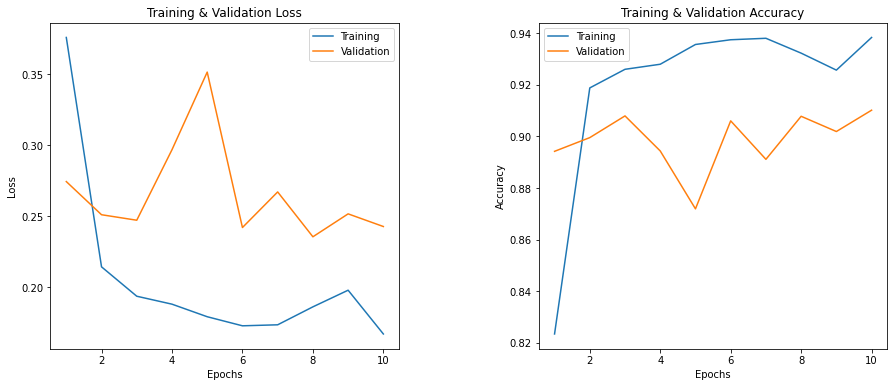

In [30]:
params = {'batch':64, 'epoch':10, 'optim':'SGD', 'lr':0.0670743, 'mm':0.744412, 'wd':0.00698397, 'seed':10}

train_loader, valid_loader = split_data(train_dataset, 
                                        train=True, 
                                        train_ratio=0.7, 
                                        batch_size=params.get('batch'), 
                                        seed=params.get('seed'),
                                        shuffle=True)

model = WasteClassifier()
model.to(device)
# performance improvements when model inputs don't change
torch.backends.cudnn.benchmark = True

train(model, train_loader, valid_loader, params, plot=True, show_updates=True)

In [26]:
test_dataset = create_dataset(train=False)
test_loader = split_data(test_dataset,
                        train=False,
                        batch_size=params.get('batch'), 
                        seed=params.get('seed'),
                        shuffle=True)

In [27]:
best_model = WasteClassifier()
load_model_from_drive(best_model, device, "resnet_lr_0_067_bs_64_sgd_mm_0_744_wd_0_0069")
best_model.to(device)

Mounted at drive


WasteClassifier(
  (resnet_feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

### Test accuracy and confusion matrix

Accuracy: 0.91484282


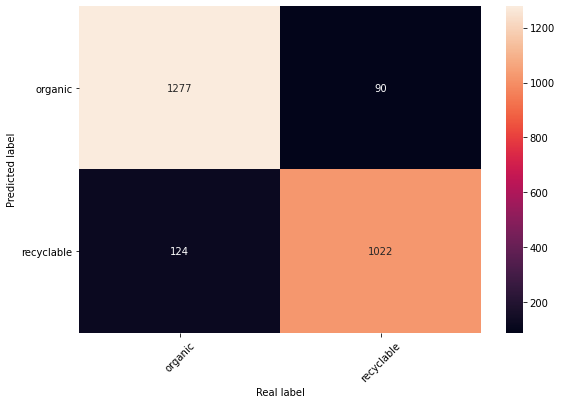

In [31]:
plot_confusion_matrix(model, test_loader)